In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
np.random.seed(1)
from datetime import datetime
from mpl_toolkits.basemap import Basemap as Basemap
from geopy.distance import vincenty
from itertools import permutations
from IPython.display import display
import GPy
import warnings
warnings.filterwarnings("ignore")

# Read In Weather Data.

## Filenames FIELDNAME_Segregated.csv

### FIELDNAME	,  Description
#### AQI  
> calculated AQI value for the station and hour (An air quality index (AQI) is a number used by government agencies to communicate to the public how polluted the air currently is or how polluted it is forecast to become. As the AQI increases, an increasingly large percentage of the population is likely to experience increasingly severe adverse health effects.)

#### PM2.5	

>Particulate Matter 2.5 micron diameter   µg/m3 (micrograms per cubic metre)

####  PM2.5_24h	  
>Average of the PM2.5 observations for the past 24 hours at time of reporting 

#### PM10	
> Particulate Matter 10 micron diameter  µg/m3 (micrograms per cubic metre)

#### PM10_24h	 
> Average of the PM10 observations for the past 24 hours at time of reporting

#### SO2	SOX  
>SodiumDioxide  pphm (parts per hundred million)

#### SO2_24h	 
>Average of the SO2 observations for the past 24 hours at time of reporting

#### NO2	
>NOX  NitrogenDioxide   pphm (parts per hundred million)

#### NO2_24h	  
>Average of the NO2 observations for the past 24 hours at time of reporting

#### O3	Ozone   
>pphm (parts per hundred million)

#### O3_24h	  
>Average of the O3 observations for the past 24 hours at time of reporting

#### O3_8h	  
>Average of the O3 observations for the past 8 hours at time of reporting

#### O3_8h_24h	  
>Average of the O3 observations for the past 8 to 24 hours at time of reporting

#### CO	
>CarbonMonoxide  ppm (parts per million)

#### CO_24h    
>Average of the CO observations for the past 24 hours at time of reporting


In [2]:
#Used to preprocess pollution data obtained from https://dataverse.harvard.edu/dataverse.xhtml?alias=cga_aqi
def preprocess_pollution_data(inputdir):
    parse = lambda x: datetime.strptime(x, '%Y%m%d %H')
    types_dict=dict()
    
    for idx,item in enumerate(glob.glob(pollutiondata_input+"china_sites*.csv")):
        print("-------------\n-----------\n",idx,item)
        tmp=pd.read_csv(item,parse_dates=[['date','hour']],date_parser=parse)
        tmp.index=tmp.date_hour
        tmp.drop('date_hour',axis=1,inplace=True)
        types=tmp.type.unique()
        for _type in types:
            if _type in types_dict.keys():
                #print(_type,tmp[tmp['type']==_type].shape)
                types_dict[_type].append(tmp[tmp['type']==_type])
            else:
                types_dict[_type]=[tmp[tmp['type']==_type]]

    for _type in types_dict.keys():
        print("\nFor Type",_type)
        types_dict[_type]=pd.concat(types_dict[_type])
        types_dict[_type].to_csv(inputdir+_type+"_segregated.csv")
    
    return types_dict

In [3]:
#Leave commented for now. Can be uncommented if raw data needs to be pre-processed (not required for running the rest of this notebook).
#%%time
#pollution_dict=preprocess_pollution_data(pollutiondata_input)

# Read Preprocessed Data

In [4]:
#Read AQI
inputfile="../datasets/airpollution/AQI_segregated.csv"
aqi_df=pd.read_csv(inputfile,parse_dates=True,infer_datetime_format=True,index_col='date_hour')
aqi_df.dropna(axis=1,thresh=int(aqi_df.shape[0]*0.99),inplace=True) #Drop Stations with less than 99% non-NaN values.
aqi_df.interpolate(method='linear',limit_direction='both',axis=0,inplace=True) 
aqi_df.head(2)

,type,1015A,1017A,1025A,1029A,1030A,1032A,1034A,1036A,1037A,...,2684A,2685A,2688A,2694A,2696A,2706A,2707A,2710A,2711A,2846A
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,AQI,221.0,189.0,37.0,28.0,36.0,18.0,14.0,71.0,69.0,...,113.0,60.0,107.0,82.0,225.0,55.0,28.0,115.0,228.0,153.0
2016-01-01 01:00:00,AQI,209.0,185.0,37.0,114.0,128.0,140.0,145.0,267.0,302.0,...,129.0,58.0,102.0,92.0,252.0,48.0,28.0,95.0,231.0,137.0


In [5]:
# Read In Location Dataset
stationlocations_inputdata="../datasets/airpollution/station_locations_china.csv"
stnloc_df=pd.read_csv(stationlocations_inputdata)
stnloc_df.drop('note',axis=1,inplace=True)
stnloc_df= stnloc_df[stnloc_df.StationID.isin(aqi_df.columns)]
stnloc_df.head(2)

,StationID,StationNM,CityNM,Long,Lat
14,1015A,勤俭路,天津,117.145,39.1654
16,1017A,大直沽八号路,天津,117.237,39.1082


# Spatial Sampling

In [6]:
def get_pairwise_distances(stnloc_df):
    pairwise_distances=dict()

    for idx,row in stnloc_df.iterrows():
        #print(idx)
        stnid=row['StationID']
        lon=row['Long']
        lat=row['Lat']
        for idx2,row2 in stnloc_df[stnloc_df['StationID']!=stnid].iterrows():
            stnid2=row2['StationID']
            lon2=row2['Long']
            lat2=row2['Lat']
            _dist=vincenty((lon,lat),(lon2,lat2)).meters
            try:
                pairwise_distances[stnid].append((stnid2,_dist))
            except KeyError:
                pairwise_distances[stnid]=[(stnid2,_dist)]
    return pairwise_distances

def randomly_sample(pairwise_distances,kind='random',n=10,topn=50):
    """
        We do two kinds of sampling:
        kind= random -> Randomly sample `n` stations without paying attention to location.
        kind= spatial -> Randomly sample the first of `n` stations, then sample the rest of the 9 stations using 
                         an iterative maximal distance approach.
    """
    all_stationids=list(pairwise_distances.keys())
    stationids=list()
    if kind=='random':
        while len(stationids)<n:
            idx=np.random.randint(0,len(all_stationids))
            stn=all_stationids[idx]
            if stn not in stationids:
                stationids.append(stn)
            #print(stn) 
    elif kind=='spatial_farthest':
        while len(stationids)<n:
            if len(stationids)==0:
                idx=np.random.randint(0,len(all_stationids)) #Randomly sample the first station.
                stn=all_stationids[idx]
                stationids.append(stn)
            else:
                prevstn=stationids[-1]
                topn_farthest_stations=sorted(pairwise_distances[prevstn],
                                              key=lambda x: x[1],reverse=True)[:topn]
                
                for farthest_stn,dist in topn_farthest_stations:
                    if farthest_stn not in stationids:
                        stationids.append(farthest_stn)
                        break
                        
    elif kind=='spatial_random':
        prevstn=stationids[-1][0]
        topn_farthest_stations=sorted(pairwise_distances[prevstn],
                                      key=lambda x: x[1],reverse=True)[:topn]

        for item in topn_farthest_stations:
            idx=np.random.randint(0,len(topn_farthest_stations))
            stn=topn_farthest_stations[idx]
            if stn not in stationids:
                stationids.append(stn)
                break
    return stationids

In [7]:
%%time
pairwise_distances=get_pairwise_distances(stnloc_df) #Calculate Distances pairwise

CPU times: user 28.9 s, sys: 108 ms, total: 29 s
Wall time: 29.5 s


In [8]:
numstations=20 #Number of stations to randomly sample. To be used in training.
randomlysampled_stnids=randomly_sample(pairwise_distances,kind='random',n=numstations,topn=50)

# Plot Lat Long Station Data

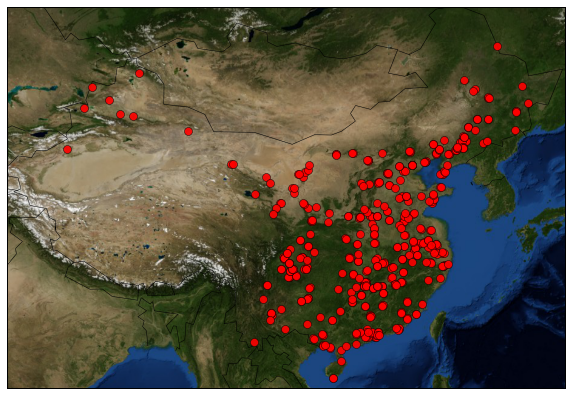

In [9]:
#Plot All Stations
#China Bounding Box W=73.6753792663, S=18.197700914, E=135.026311477, N=53.4588044297
m=Basemap(projection='mill',llcrnrlat=17.197700914,urcrnrlat=53.4588044297,llcrnrlon=73.6753792663,urcrnrlon=135.026311477,resolution='c')
plt.figure(figsize=(10,10))

pos={}
for idx,row in stnloc_df.iterrows():
    stnid=row['StationID']
    lat=row['Lat']
    lon=row['Long']
    name=row['StationNM']
    mx,my=m(lon,lat)
    m.plot(mx,my,'ro',markersize=8,alpha=0.9)

# Now draw the map
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

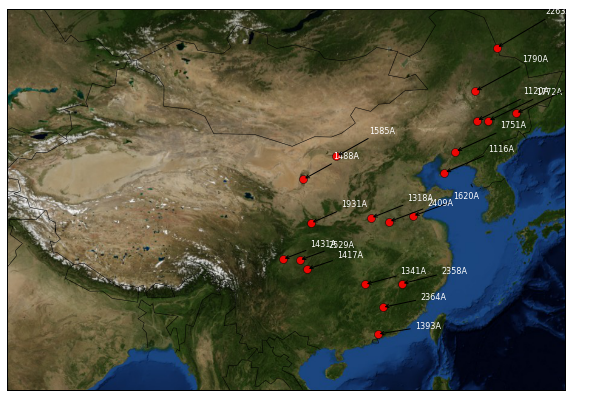

In [10]:
#Plot and Annotate only the sampled stations.
#China Bounding Box W=73.6753792663, S=18.197700914, E=135.026311477, N=53.4588044297
m=Basemap(projection='mill',llcrnrlat=17.197700914,urcrnrlat=53.4588044297,llcrnrlon=73.6753792663,urcrnrlon=135.026311477,resolution='c')
plt.figure(figsize=(10,10))

pos={}
for idx,row in stnloc_df.iterrows():
    stnid=row['StationID']
    lat=row['Lat']
    lon=row['Long']
    name=row['StationNM']
    mx,my=m(lon,lat)
    if stnid in randomlysampled_stnids:
        m.plot(mx,my,'ro',markersize=8,alpha=0.9)
        plt.annotate(stnid,xy=(mx, my),xycoords='data',xytext=(mx+0.1*mx, my+0.1*my),
                      textcoords='data',arrowprops=dict(arrowstyle="->"),fontsize=8,color='w')

# Now draw the map
m.drawcountries()
m.drawstates()
m.bluemarble()
plt.show()

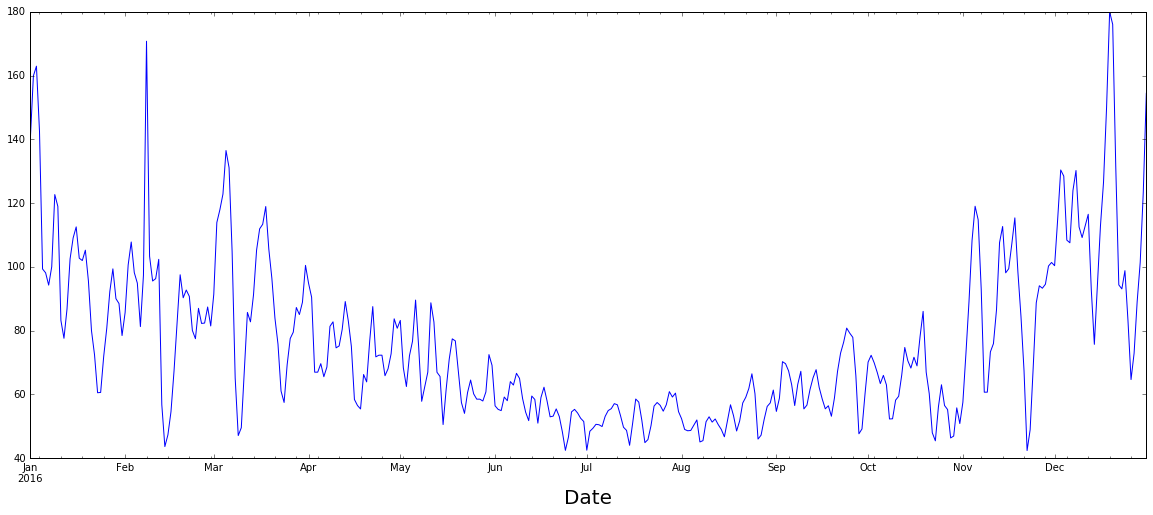

In [11]:
#Average Air Quality Index across all stations in China.
fig,ax=plt.subplots(1,1,figsize=(20,8))
aqi_df.resample('D').mean().mean(axis=1).plot(ax=ax)
ax.set_xlabel('Date',fontsize=20)

In [12]:
aqi_daily_df=aqi_df.resample('D').mean()
aqi_daily_df.head(2)

,1015A,1017A,1025A,1029A,1030A,1032A,1034A,1036A,1037A,1038A,...,2684A,2685A,2688A,2694A,2696A,2706A,2707A,2710A,2711A,2846A
date_hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01,245.666667,200.291667,215.750000,307.5,277.583333,322.375000,290.166667,215.416667,243.875000,214.583333,...,91.416667,66.000000,105.375000,90.250000,212.333333,56.458333,28.958333,149.750000,181.666667,107.125000
2016-01-02,437.583333,459.166667,386.416667,494.0,454.666667,491.541667,472.833333,366.541667,396.166667,355.833333,...,94.000000,57.791667,86.416667,109.166667,177.458333,46.750000,29.583333,238.458333,301.750000,81.083333


# Simple Gaussian Process Example with Synthetic Data

In [13]:
def sample_gaussian_process_plots():
    for i in np.arange(5,1006,500):  #Generate values in increments of 500 from 5 - 1006
        X = np.random.uniform(-3.,3.,(i,1))  #Generate values between -3 and 3 sampled from a uniform distribution.
        Y = np.sin(X) + np.random.randn(i,1)*0.05 + np.random.randn(i,1)
        kernel = GPy.kern.RBF(input_dim=1, variance=20, lengthscale=1.)
        m = GPy.models.GPRegression(X,Y,kernel)
        display(m)
        fig = m.plot()
        plt.title("Num Points "+str(i),fontsize=20)
        plt.ylim(-8,8)
        GPy.plotting.show(fig)

GP_regression.,value,constraints,priors
rbf.variance,20.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,20.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,20.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


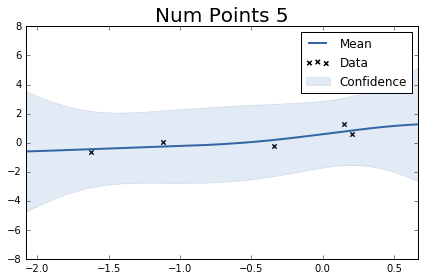

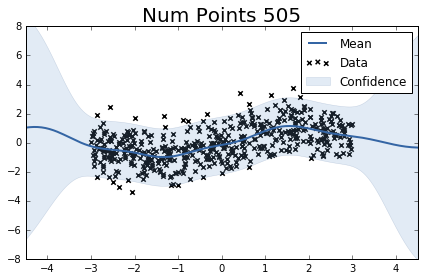

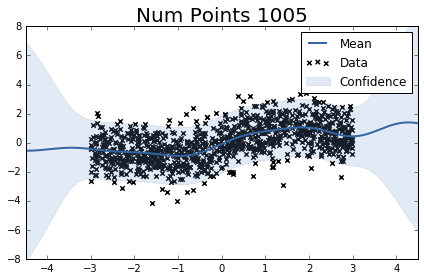

In [14]:
sample_gaussian_process_plots()

# Step-By-Step Gaussian Process Regression Fit and Predict Example

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


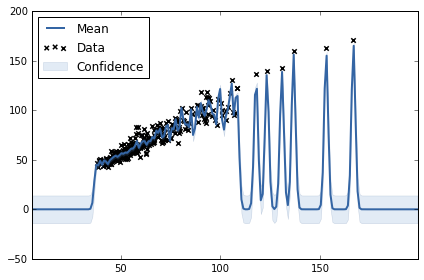

In [15]:
num_stns=20
train_thr=0.8  #How much of the data to use for training.
 
randomlysampled_stnids=randomly_sample(pairwise_distances,kind='random',n=num_stns,topn=50) #Randomly sample stations.

#Split data into training and testing sets.
train_idx=int(train_thr*aqi_daily_df.shape[0])
X_train=aqi_daily_df[randomlysampled_stnids].mean(axis=1).iloc[:train_idx]
X_test=aqi_daily_df[randomlysampled_stnids].mean(axis=1).iloc[train_idx:]
y_train=aqi_daily_df.mean(axis=1).iloc[:train_idx]
y_test=aqi_daily_df.mean(axis=1).iloc[train_idx:]


#Fit GP using training data.
kernel = GPy.kern.RBF(input_dim=1, variance=50, lengthscale=1.) #Define a kernel
m = GPy.models.GPRegression(X_train[:,np.newaxis],y_train[:,np.newaxis],kernel) #Fit regression model using training and testing data.
display(m) #Display GP_regression table 
m.plot() #Display Training Data Fit.
plt.legend(loc='upper left')

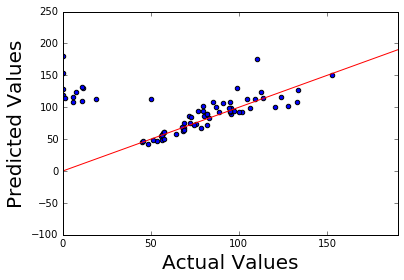

In [16]:
pred_mean,pred_var=m.predict(X_test[:,np.newaxis])  #Predict test data using fitted GP model.

#Plot results (pred_mean = predictions)
plt.xlabel('Actual Values',fontsize=20)
plt.ylabel('Predicted Values',fontsize=20)
plt.scatter(pred_mean[:,np.newaxis],y_test[:,np.newaxis])  #Pred vs. Actual
x = np.linspace(*plt.xlim())
plt.xlim(0,190)
plt.plot(x, x,color='r')

# Define Gaussian Process Fit and Predict Helper Functions

In [17]:
def fit_gp(aqi_daily_df,randomly_sampled_stnids,train_thr=0.8):
    train_idx=int(train_thr*aqi_daily_df.shape[0])
    X_train=aqi_daily_df[randomlysampled_stnids].mean(axis=1).iloc[:train_idx]
    X_test=aqi_daily_df[randomlysampled_stnids].mean(axis=1).iloc[train_idx:]

    y_train=aqi_daily_df.mean(axis=1).iloc[:train_idx]
    y_test=aqi_daily_df.mean(axis=1).iloc[train_idx:]

    kernel = GPy.kern.RBF(input_dim=1, variance=50, lengthscale=1.)
    m = GPy.models.GPRegression(X_train[:,np.newaxis],y_train[:,np.newaxis],kernel)
    display(m)
    m.plot()
    plt.legend(loc='upper left')
    return m,X_train,X_test,y_train,y_test
    
def predict_gp(m,X_test,y_test):
    pred_mean,pred_var=m.predict(X_test[:,np.newaxis]) #m is the Gaussian Process instance which has already been fit.
    plt.xlabel('Actual Values',fontsize=20)
    plt.ylabel('Predicted Values',fontsize=20)
    plt.scatter(pred_mean[:,np.newaxis],y_test[:,np.newaxis])  #Pred vs. Actual
    x = np.linspace(*plt.xlim())
    plt.xlim(0,190)
    plt.plot(x, x,color='r')

# Train with 20 stations

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


CPU times: user 131 ms, sys: 4.98 ms, total: 136 ms
Wall time: 227 ms


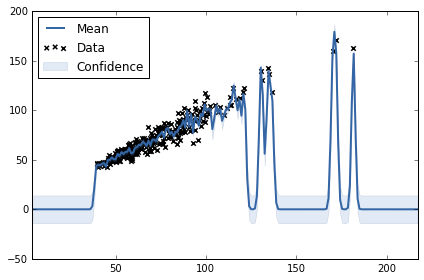

In [18]:
%%time
num_stns=20
randomlysampled_stnids=randomly_sample(pairwise_distances,kind='random',n=num_stns,topn=50)
gp,X_train,X_test,y_train,y_test=fit_gp(aqi_daily_df,randomlysampled_stnids,train_thr=0.8)

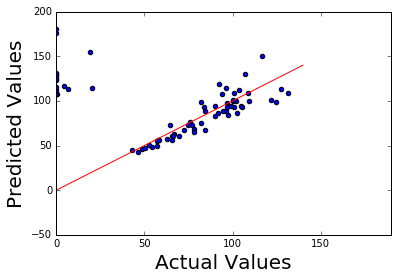

In [19]:
predict_gp(gp,X_test,y_test)

# Train with 50 Randomly Sampled Stations

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


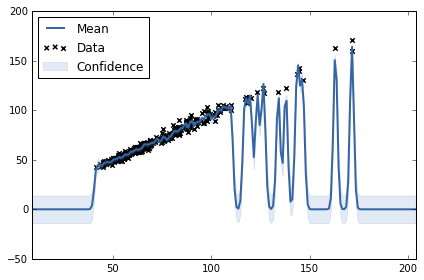

In [20]:
num_stns=50
randomlysampled_stnids=randomly_sample(pairwise_distances,kind='random',n=num_stns,topn=50)
gp,X_train,X_test,y_train,y_test=fit_gp(aqi_daily_df,randomlysampled_stnids,train_thr=0.8)

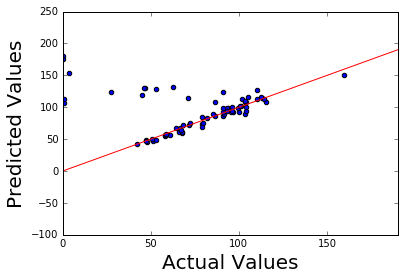

In [21]:
predict_gp(gp,X_test,y_test)

# Train with 200 Stations

GP_regression.,value,constraints,priors
rbf.variance,50.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


CPU times: user 140 ms, sys: 4.88 ms, total: 145 ms
Wall time: 236 ms


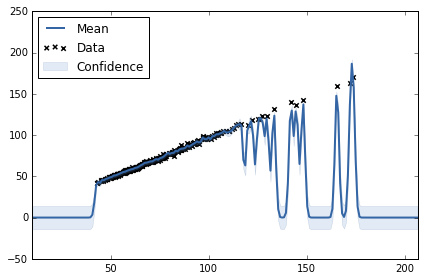

In [22]:
%%time
num_stns=200
randomlysampled_stnids=randomly_sample(pairwise_distances,kind='random',n=num_stns,topn=50)
gp,X_train,X_test,y_train,y_test=fit_gp(aqi_daily_df,randomlysampled_stnids,train_thr=0.8)

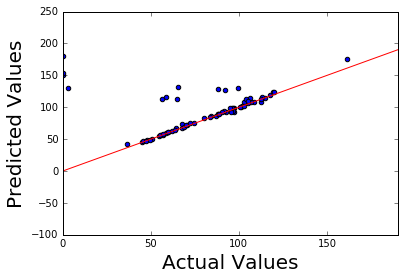

In [23]:
predict_gp(gp,X_test,y_test)